In [ ]:
# Importing necessary libraries
import pandas as pd
import regex as re
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping

In [29]:
# Loading data
train_file = 'MIMIC_III_train.csv'
test_file = 'MIMIC_III_test.csv'
validation_file = 'MIMIC_III_validation.csv'

train = pd.read_csv(train_file, index_col=0)
test = pd.read_csv(test_file, index_col=0)
validation = pd.read_csv(validation_file, index_col=0)

In [30]:
# Selecting relevant columns
train = train[['TEXT', 'DIAGNOSIS']]
test = test[['TEXT', 'DIAGNOSIS']]
validation = validation[['TEXT', 'DIAGNOSIS']]

In [31]:
# Text preprocessing function
def preprocess(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text, re.I|re.A)  # Remove non-alphanumeric characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)  # Remove single characters
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)  # Remove single characters from the start
    text = re.sub(r'\s+', ' ', text, flags=re.I)  # Substitute multiple spaces with single space
    text = re.sub(r'^b\s+', '', text)  # Remove prefixed 'b'
    text = text.lower()  # Convert to lowercase
    return text

In [32]:
# Applying text preprocessing to the data
train['TEXT'] = train['TEXT'].apply(preprocess)
test['TEXT'] = test['TEXT'].apply(preprocess)
validation['TEXT'] = validation['TEXT'].apply(preprocess)

In [33]:
# Tokenizing and padding sequences
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train['TEXT'].values)
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Found 60530 unique tokens.


In [34]:
# Pad sequences for train, test, and validation
X_train = pad_sequences(tokenizer.texts_to_sequences(train['TEXT'].values), maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(test['TEXT'].values), maxlen=MAX_SEQUENCE_LENGTH)
X_validation = pad_sequences(tokenizer.texts_to_sequences(validation['TEXT'].values), maxlen=MAX_SEQUENCE_LENGTH)

In [35]:
# Convert categorical labels to numbers
Y_train = pd.get_dummies(train['DIAGNOSIS']).values
Y_test = pd.get_dummies(test['DIAGNOSIS']).values
Y_validation = pd.get_dummies(validation['DIAGNOSIS']).values

In [36]:
# Print proportions of each class
unique, counts = np.unique(train['DIAGNOSIS'], return_counts=True)
total = sum(counts)
print("Proportions of each class:")
for i in range(len(unique)):
    print(unique[i], counts[i]/total)

Proportions of each class:
ABDOMINAL PAIN 0.0174
ALTERED MENTAL STATUS 0.0109
CHEST PAIN 0.0025666666666666667
CONGESTIVE HEART FAILURE 0.013966666666666667
CORONARY ARTERY DISEASE 0.015866666666666668
FEVER 0.0030666666666666668
INTRACRANIAL HEMORRHAGE 0.0012
NEWBORN 0.3191
Other 0.5709666666666666
PNEUMONIA 0.021766666666666667
SEPSIS 0.0232


In [37]:
# Create the model
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(Y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
# Training the model
epochs = 5
batch_size = 64

history = model.fit(
    X_train, Y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_validation, Y_validation),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
)

Epoch 1/5
  1/469 [..............................] - ETA: 50:34 - loss: 2.3977 - accuracy: 0.0781

KeyboardInterrupt: 

In [ ]:
# Evaluate model on test set
accr = model.evaluate(X_test, Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0], accr[1]))

313/313 [==============================] - 31s 98ms/step - loss: 0.7890 - accuracy: 0.8436
Test set
  Loss: 0.789
  Accuracy: 0.844


In [ ]:
# Predictions on test set
y_pred = model.predict(X_test)

# Convert predictions to one-hot encoded format
y_pred_one_hot = np.zeros_like(y_pred)
y_pred_one_hot[np.arange(len(y_pred)), y_pred.argmax(axis=1)] = 1

# Calculate accuracy for each diagnosis
correctly_predicted = (Y_test * y_pred_one_hot).sum(axis=0)
total_samples = Y_test.sum(axis=0)

# Print proportion of each diagnosis correctly predicted
print("\nProportion of each diagnosis correctly predicted:")
for i in range(len(unique)):
    diagnosis = unique[i]
    accuracy = correctly_predicted[i] / total_samples[i]
    print(f"{diagnosis}: {accuracy:.2%}")

313/313 [==============================] - 35s 110ms/step

Proportion of each diagnosis correctly predicted:
ABDOMINAL PAIN: 0.00%
ALTERED MENTAL STATUS: 0.00%
CHEST PAIN: 0.00%
CONGESTIVE HEART FAILURE: 0.00%
CORONARY ARTERY DISEASE: 0.00%
FEVER: 0.00%
INTRACRANIAL HEMORRHAGE: 0.00%
NEWBORN: 98.55%
Other: 99.11%
PNEUMONIA: 1.04%
SEPSIS: 0.00%


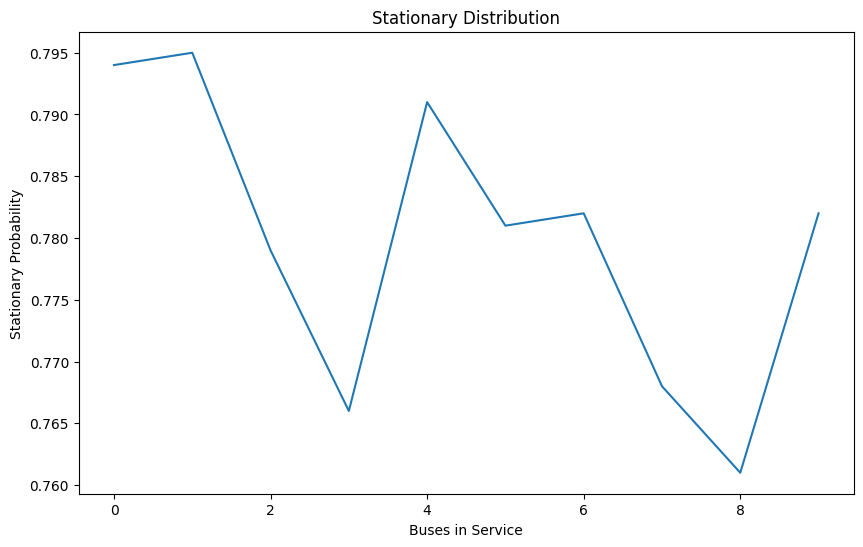

In [50]:
import numpy as np

np.random.seed(0)

# initialize parameters
mu = 1.2
lambda_ = 2.1
num_buses = 10
time_units = 1000

# initialize variables
buse_in_service = np.ones(num_buses)
bus_repair_time_remaining = np.zeros(num_buses)
states = np.zeros((time_units, num_buses))

# simulate process
for t in range(time_units):
    # check if any bus breaks down
    for i in range(num_buses):
        if np.random.rand() < mu / (mu + lambda_) and buse_in_service[i] == 1:
            buse_in_service[i] = 0
            bus_repair_time_remaining[i] = np.random.exponential(mu)
    # check if any bus is repaired
    for i in range(num_buses):
        if bus_repair_time_remaining[i] > 0:
            bus_repair_time_remaining[i] -= 1
            if bus_repair_time_remaining[i] <= 0:
                buse_in_service[i] = 1
                bus_repair_time_remaining[i] = 0
    # record state
    states[t, :] = buse_in_service
    
# Plot stationary distribution
import matplotlib.pyplot as plt

# include all 10 ticks
plt.xticks(range(11))
plt.figure(figsize=(10, 6))
plt.plot(states.mean(axis=0))
plt.xlabel('Buses in Service')
plt.ylabel('Stationary Probability')
plt.title('Stationary Distribution')
plt.show()



